# Understanding Recency Space
Use `RecencySpace` to embed datetime signals and configure your embeddings to favor a specific recency profile.

In [1]:
%pip install superlinked==19.19.0

## Recency Space

In [2]:
from datetime import datetime, timedelta
import altair as alt
from superlinked import framework as sl

# Enable visualization on Github.
# Ref: https://altair-viz.github.io/user_guide/display_frontends.html
alt.renderers.enable(sl.get_altair_renderer())


class Post(sl.Schema):
    id: sl.IdField
    created_at: sl.Timestamp  # Capture date and time as a unix timestamp in seconds.


post = Post()

recency_space = sl.RecencySpace(timestamp=post.created_at)  # Create a recency space to embed datetime information.

Use the `RecencyPlotter` to visualize the value set of the `RecencySpace`.

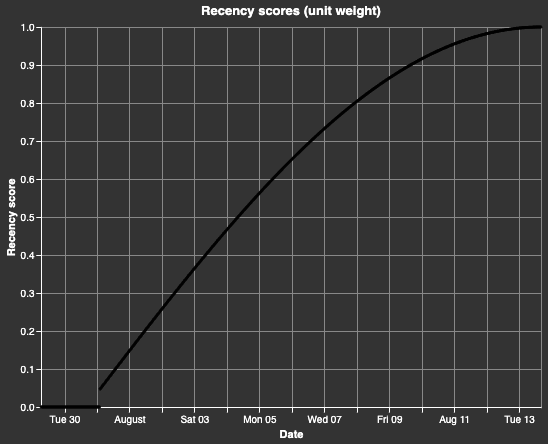

In [3]:
sl.RecencyPlotter(recency_space).plot_recency_curve()

## Periods
You can provide the recency space key dates of interest (periods) to customize the recency space to your requirements.

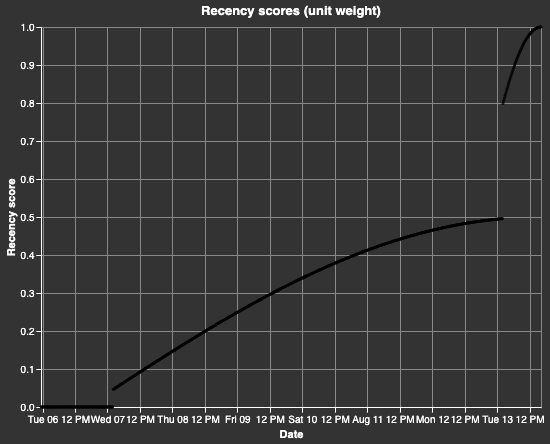

In [4]:
custom_recency_space = sl.RecencySpace(
    timestamp=post.created_at,
    period_time_list=[
        sl.PeriodTime(timedelta(days=1)),  # One unit of the signal should be the previous day.
        sl.PeriodTime(timedelta(days=7)),  # Another unit should be the previous week.
        # Anything else should get a zero score.
    ],
)

sl.RecencyPlotter(custom_recency_space).plot_recency_curve()

## Weighted periods
Use weights to give more importance to some periods.

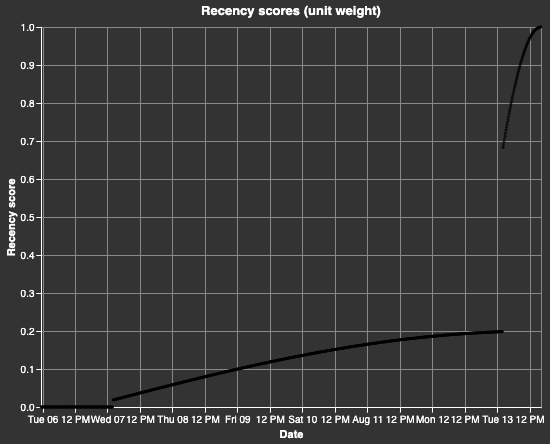

In [5]:
weighted_recency_space = sl.RecencySpace(
    timestamp=post.created_at,
    period_time_list=[
        sl.PeriodTime(timedelta(days=1), weight=2),  # You can tune the ratio with weights.
        sl.PeriodTime(timedelta(days=7)),
    ],
)

sl.RecencyPlotter(weighted_recency_space).plot_recency_curve()

## Setting NOW to a specific date

During execution the RecencySpace will pick up on the NOW timestamp of the system, to allow you to experiment with historical data you can set the time to a specific date with the following code. CONTEXT_DATA will need to be supplied to the executor.

In [6]:
CONTEXT_DATA = {sl.CONTEXT_COMMON: {sl.CONTEXT_COMMON_NOW: int(datetime(2024, 8, 10).timestamp())}}

## Querying recency

When querying with recency, no input is necessary - recency will always be assessed compared to the system's `NOW`.

In [7]:
index = sl.Index([recency_space])

source: sl.InMemorySource = sl.InMemorySource(post)
executor = sl.InMemoryExecutor(sources=[source], indices=[index], context_data=CONTEXT_DATA)
app = executor.run()

In [8]:
source.put(
    [
        {"id": "post-1", "created_at": int(datetime(2024, 8, 8).timestamp())},
        {"id": "post-2", "created_at": int(datetime(2024, 8, 6).timestamp())},
        {"id": "post-3", "created_at": int(datetime(2024, 8, 2).timestamp())},
        {"id": "post-4", "created_at": int(datetime(2024, 7, 31).timestamp())},
    ]
)

In [9]:
recency_result = app.query(sl.Query(index).find(post).select_all())
sl.PandasConverter.to_pandas(recency_result)

,created_at,id,similarity_score
0,1723068000,post-1,0.974928
1,1722895200,post-2,0.900969
2,1722549600,post-3,0.623490
3,1722376800,post-4,0.433884


The query results are chronologically ordered just as we would expect them to be.